# TASK 2. R2* Mapping (Multi-Layer Perceptron)

### **We are going to train the MLP to estimate the R2* of each voxel using MRI data. The overall procedure is following:**

> **1. Data preparation**  
**2. define the network architecture**  
**3. train the network**  
**4. test the trianed network**  


![ ](https://blogfiles.pstatic.net/MjAxOTA5MTBfMTUw/MDAxNTY4MTAzNDExNjEx.1mLJ0eR2qgTUql3Rg8eZ52urXAvz1z5aaK39xmp3JEUg.ccAfmkXluOlasS80oOtOsxEN-ZTqyf5mjsVLGUM_R7Ig.PNG.susie1513/process.png)



In [0]:
# import libraries
# don't forget to do drive mount for data loading

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import h5py

# 1. Data Preparation 

### First, we have to load the MRI simulation data. Since collecting wide range of in vivo signals is difficult, we use simulation data for training. For simulation data, mono-exponential decay is used with following ranges of input variables : A ∈ [0.8,0.81,...,1.5] ,  T2 * ∈ [10,11,...299,300,310,...,1500] ms.


![ ](https://postfiles.pstatic.net/MjAxOTA5MTBfMjgx/MDAxNTY4MTAzMTA3MDQy.qeHFDVnYxIaGpHot_2aMCeDK5NhnzB7vyyrhwBBROZ0g.uVvsJRE-M1Jj4ivhIxZCU3aph0tm4kVNQacevDnL1wwg.PNG.susie1513/monodecay.png?type=w580
)

In [0]:
f = h5py.File('/content/drive/My Drive/Colab Notebooks/TASK2.Data/train_R2s.h5', 'r')

X_train = f['X_train']
X_train = np.float32(X_train)
X_train = torch.from_numpy(X_train)

Y_train = f['Y_train']
Y_train = np.float32(Y_train)
Y_train = torch.from_numpy(Y_train)

print(X_train.shape)
print(Y_train.shape)

torch.Size([244620, 11])
torch.Size([244620, 1])


# 2. Define the network architecture 

### Now we will define our own network architecture. The network takes a 11 echo MRI signals, and yields R2* value of each voxel. We used mean-squared-error which is commonly adopted in regression problems.


![ ](https://postfiles.pstatic.net/MjAxOTA5MTFfMjY2/MDAxNTY4MTk4MTMwMjkx.G7TvEFeAXjt6Wmd6mcAgrRxQOsuC6XV7CCyfZmi9LHgg.IEoWPd7JFZMrips8uNxdwbSiK1v364n96szYfOmmqMwg.PNG.susie1513/networks.png?type=w580
)


In [0]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [0]:
class R2s_model(nn.Module):
    
    def __init__(self):
        super(R2s_model, self).__init__()       
        self.fc1 = nn.Linear(11, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 1)  
        
        # gpu setting
        if use_cuda:
            self.fc1 = self.fc1.cuda()
            self.fc2 = self.fc2.cuda()
            self.fc3 = self.fc3.cuda()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))       
        x = F.relu(self.fc2(x))
        x = nn.Sigmoid()(self.fc3(x))
        return x
    
model = R2s_model()
print(model)

# loss function
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

R2s_model(
  (fc1): Linear(in_features=11, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


# 3. Train the network

### The steps for training are 



> **1. Clear the gradients of all variables**  
**2. Compute the predicted outputs by passing foward inputs to the model (forward pass)**  
**3. Calcuate the loss using the loss function that we defined**  
**4. Compute the gradient of the loss**  
**5. Perform a single optimization step**

In [0]:
batch_size = 5000
n_batches = X_train.shape[0]//batch_size
n_epoch = 200

plot_loss = []

model.train()

for epoch in range(n_epoch):
    
    train_loss = 0.0  
    iteration = 0
        
    for ii in range(n_batches):

        x_train = Variable(X_train[ii*batch_size:(ii+1)*batch_size,:], requires_grad = True)
        y_train = Variable(Y_train[ii*batch_size:(ii+1)*batch_size,:], requires_grad = True)
      
        if use_cuda:
            x_train = x_train.cuda()
            y_train = y_train.cuda()
        
        # 1. clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # 2. forward pass
        res_x = model(x_train)
        
        # 3. calculate the loss
        loss = criterion(res_x, y_train)
        
        # 4. backward pass
        loss.backward()
        
        # 5. parameter update
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()
        iteration += 1
        
    # calculate average loss over one epoch    
    train_loss = train_loss/iteration
    
    if (epoch+1)%5 == 0 :
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))



Epoch: 5 	Training Loss: 0.004654
Epoch: 10 	Training Loss: 0.000988
Epoch: 15 	Training Loss: 0.000695
Epoch: 20 	Training Loss: 0.000524
Epoch: 25 	Training Loss: 0.000416
Epoch: 30 	Training Loss: 0.000344
Epoch: 35 	Training Loss: 0.000294
Epoch: 40 	Training Loss: 0.000257
Epoch: 45 	Training Loss: 0.000228
Epoch: 50 	Training Loss: 0.000205
Epoch: 55 	Training Loss: 0.000183
Epoch: 60 	Training Loss: 0.000165
Epoch: 65 	Training Loss: 0.000151
Epoch: 70 	Training Loss: 0.000139
Epoch: 75 	Training Loss: 0.000129
Epoch: 80 	Training Loss: 0.000121
Epoch: 85 	Training Loss: 0.000114
Epoch: 90 	Training Loss: 0.000108
Epoch: 95 	Training Loss: 0.000102
Epoch: 100 	Training Loss: 0.000097
Epoch: 105 	Training Loss: 0.000092
Epoch: 110 	Training Loss: 0.000088
Epoch: 115 	Training Loss: 0.000084
Epoch: 120 	Training Loss: 0.000081
Epoch: 125 	Training Loss: 0.000078
Epoch: 130 	Training Loss: 0.000075
Epoch: 135 	Training Loss: 0.000073
Epoch: 140 	Training Loss: 0.000071
Epoch: 145 	

# 4. Test the trained network

### We test our model on unseen In vivo data and compared with conventional method.

In [0]:
# load test in vivo dataset
meas = io.loadmat('/content/drive/My Drive/Colab Notebooks/exercise_ANN/test_data_mgre.mat')
meas = meas['meas']
yy,xx,zz,ee = meas.shape

# Input normalization
meas2 = np.zeros([yy,xx,zz,ee])
for i in range(yy):
    for j in range(xx):
        for k in range(zz):
            meas2[i,j,k,:] = meas[i,j,k,:]/meas[i,j,k,0]   
            
print(meas2.shape)

# make the in vivo image to 2D torch array for network input
meas3 = np.reshape(meas2,[yy*xx*zz,ee])
meas3 = np.float32(meas3)
meas4 = torch.from_numpy(meas3)

model.eval()

if use_cuda:
    meas4 = meas4.cuda()
    
# get outputs
res_temp = model(meas4)

# perpare images for display
res_temp = res_temp.data.cpu().numpy()

# reshape the result to 3D image 
R2 = np.reshape(res_temp,[yy,xx,zz])

(192, 192, 32, 11)


Text(0.5, 1.0, '|DL - Fitting|*10')

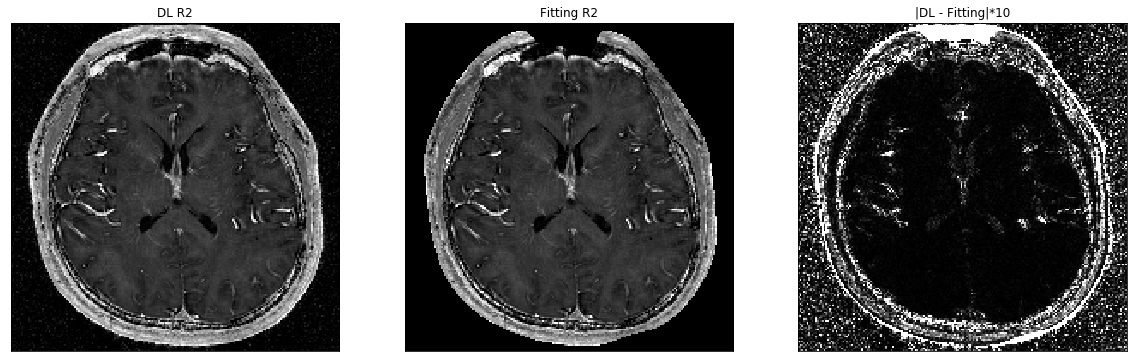

In [0]:
# load conventional fitting result to compare
label = io.loadmat('/content/drive/My Drive/Colab Notebooks/exercise_ANN/test_label_r2s.mat')
R2_true = label['R2']

# plot the images with conventional method and the differences of two images
fig = plt.figure(figsize=(20, 7))

nslice = 10
R2_pred_show = np.squeeze(R2[:,:,nslice-1:nslice])*100
R2_label_show = np.squeeze(R2_true[:,:,nslice-1:nslice])

ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
ax.imshow(np.squeeze(R2_pred_show), cmap='gray',vmin=0,vmax=100)
ax.set_title("DL R2")

ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
ax.imshow(np.squeeze(R2_label_show), cmap='gray',vmin=0,vmax=100)
ax.set_title("Fitting R2")

ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
ax.imshow(np.squeeze(np.abs(R2_pred_show-R2_label_show))*10, cmap='gray',vmin=0,vmax=100)
ax.set_title("|DL - Fitting|*10")